In [1]:
import pysolr
import pandas as pd

import pysolr
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows=200
import matplotlib as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
import numpy as np
import copy as cp
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Users/300032675/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
solrcon = pysolr.Solr('http://localhost:8984/solr/sprod', timeout=100,search_handler='query')


In [3]:
filter_queries = ['count_options_availbale: [1 TO *]', 'styletype:P' \
#                   ,'global_attr_article_type:Handbags' \
#                   ,'global_attr_sub_category:Shoes' \
                   ,'global_attr_brand:Nike' \
#                   ,'global_attr_article_type_facet:Jeans'
                 ]
field_list = ['global_attr_*','styleid','product','*_article_attr','global_attr_article_type']

In [4]:
blacklisted_attributes=['Multipack_Set_article_attr','Reversible_article_attr','Warranty_article_attr','global_attr_style_category','global_attr_fashion_type']

In [5]:
results = solrcon.search(q='*:*',fq=filter_queries,rows=100000,fl=field_list,df='full_text_myntra')

In [6]:
docs_df = pd.DataFrame(results.docs)

In [7]:
cols = [c for c in docs_df.columns if c.lower().split('_')[-1] != 'facet']
docs_df = docs_df[cols]
# removing date and colour fields
cols = [c for c in docs_df.columns if not ('date' in c or 'year' in c or 'colour' in c or 'full_text' in c or 'product' in c)]
docs_df = docs_df[cols]

In [8]:
for c in docs_df.columns :
    docs_df[c] = docs_df[c].apply(lambda lst : lst[0] if type(lst)==list else lst)

In [9]:
# vals = docs_df.global_attr_usage.drop_duplicates().tolist()
backup_df = docs_df


In [10]:
sample_size = 10000
docs_df = backup_df.head(sample_size)

# docs_df = docs_df[['global_attr_usage','global_attr_brand','Wash_Care_article_attr','styleid','global_attr_gender','Fit_article_attr']]


In [11]:
# vals =  [c for c in vals if not ((c=='NA' or c=='na'))]

In [12]:
def is_subset(left,S) :
    return all([x in S for x in left])
def is_not_empty_intersect(sub,S) :
    return any([x in S for x in sub])

In [13]:
all_cols = [c for c in docs_df.columns if docs_df[~docs_df[c].isin(['NA' ,'na' ,'nan' ,'', None])][c].dropna().count() > 0.1*sample_size and c not in blacklisted_attributes]
no_of_attr=len(all_cols)
# min_roughness_all_attributes = np.ones(no_of_attr)
docs_df = docs_df[all_cols]
all_cols


[u'Ankle_Height_article_attr',
 u'Body_or_Garment_Size_article_attr',
 u'Fabric_article_attr',
 u'Fastening_article_attr',
 u'Length_article_attr',
 u'Material_article_attr',
 u'Number_of_Components_article_attr',
 u'Occasion_article_attr',
 u'Pattern_article_attr',
 u'Print_or_Pattern_Type_article_attr',
 u'Wash_Care_article_attr',
 u'global_attr_age_group',
 u'global_attr_article_type',
 u'global_attr_brand',
 u'global_attr_gender',
 u'global_attr_gender_string',
 u'global_attr_master_category',
 u'global_attr_season',
 u'global_attr_sub_category',
 u'global_attr_usage',
 u'styleid']

In [14]:
def get_next_partitioning_attribute(docs_df):
    attribute_values_map = {}
    attribute_value_styleids = {}
    mean_roughness_map = {}
    attr_roughness={}
#     print "all_cols",all_cols
    for attr in all_cols :
        if attr =='styleid':
            continue;
        vals = docs_df[attr].dropna().drop_duplicates().tolist()
        vals =  [c for c in vals if not (c=='NA' or c=='na' or c=='nan' or c is None)]
        # to compute roughness for that attribute values wrt all other attribites
        no_of_values = len(vals)

        # store the number of unique values per attribute
        attribute_values_map[attr] = vals
        
        roughness_of_attr = np.ones((no_of_attr,no_of_values))
        col_num = 0
        row_num=0;
        min_roughness = 1.0
        print attr
#         print attr,vals
        # we donot want to split on attributes which have only 1 value or lesser
        if no_of_values <= 1 :
            continue;
        
        for value in vals:
            X = docs_df[docs_df[attr]==value]
            X_styleids = X['styleid'].drop_duplicates().tolist()
            # store the filtered styleids for faster computation
            if attr not in attribute_value_styleids :
                attribute_value_styleids[attr] = {}
            attribute_value_styleids[attr][value] = X_styleids
            # for each value compute the roughness wrt other attributes
            for at in all_cols :
                if at == attr or at=='styleid' :
                    continue
                # for this attribute find all values present in X
                at_vals_X = X[at].drop_duplicates().tolist()
                min_set = []
                max_set = []
                for at_val in at_vals_X:
                    if at in attribute_value_styleids and at_val in attribute_value_styleids[at] :
                        at_val_styleids = attribute_value_styleids[at][at_val]
                    else :
                        at_val_styleids = docs_df[docs_df[at]==at_val]['styleid'].drop_duplicates().tolist()
                    
                    if is_subset(at_val_styleids,X_styleids) :
                        min_set.extend(at_val_styleids)
                    if is_not_empty_intersect(at_val_styleids,X_styleids) :
                        max_set.extend(at_val_styleids)
                lMax = len(max_set)
                if lMax != 0 :
                    roughness = (1-(len(min_set)*1.0/lMax));
                else :
                    # TODO revisit this
                    roughness = 1
                roughness_of_attr[all_cols.index(at)][vals.index(value)] = roughness
        # store the table generated for each attribute value (small, medium, big) 
        # and other attributes(a2,a3,a4,a5) 
        # for the current attribute a1
        attr_roughness[attr] = roughness_of_attr
        
        # compute mean roughness for each other attribute
        mean_roughness_map[attr] =[]
        for row in roughness_of_attr :
            score =(sum(row) -1.0)*1.0/no_of_values;
            mean_roughness_map[attr].append(score)
            
            
    if len(mean_roughness_map) ==0 :
        return {}
    # tables and mean roughness for all attributes are generated
    attr_mean_roughness_copy_map = {}
#     print "mean_roughness_map", mean_roughness_map
    for key in mean_roughness_map:
        tp = cp.deepcopy(mean_roughness_map[key])
        tp.sort()
        attr_mean_roughness_copy_map[key] = tp
    
    # find the minimum of list of mean roughnesses
    min_list =  min(attr_mean_roughness_copy_map.values())
    # find the attribute wrt which the roughness is minimum
    for k in attr_mean_roughness_copy_map :
        if attr_mean_roughness_copy_map[k] == min_list :
            min_rough_attribute = k
    # get the roughness table which was earlier computed
    roughness_of_attr = attr_roughness[min_rough_attribute]
    # values becomes rows and other attributes becomes colums
#     transposed_array = np.transpose(mean_roughness_map[min_rough_attribute])
    transposed_array = np.transpose(roughness_of_attr)
    
    # for each row calculate the sum and select row which has minimum sum
#     print "attribute_values_map",attribute_values_map
#     print "transposed_array",transposed_array
    min_sum = 1000000+1
    for i in range(0,len(transposed_array)) :
#         print "transposed_array[i]",transposed_array[i]
        s = sum(transposed_array[i])
        if s < min_sum :
            min_sum = s
#             print "min_rough_attribute",min_rough_attribute,i
            min_value = attribute_values_map[min_rough_attribute][i]
    return {min_rough_attribute:min_value}

In [15]:
def select_cluster_to_split(cluster_docs) :
    length = len(cluster_docs)
    max_docs = 0;
    index =0;
    for i in range(0,length) :
#         print len(cluster_docs[i]),max_docs
        if len(cluster_docs[i]) > max_docs :
            max_docs = len(cluster_docs[i])
            index = i
    return index

def get_partitioned_df(df,partition_map) :
    result = df
    for attr in partition_map :
        val = partition_map[attr]
        result = result[result[attr]==val]
    return result
def get_partitioned_negative_df(df,partition_map) :
    result = df
    for attr in partition_map :
        val = partition_map[attr]
        result = result[result[attr]!=val]
    return result

In [16]:
total_clusters_required = 10
cluster_docs = []
cluster_docs.append(docs_df)
cluster_partition_attributes = []
cluster_partition_attributes.append({})
label_attributes = []
label_attributes.append({})
for num in range(0,total_clusters_required) :
    ind = select_cluster_to_split(cluster_docs)
    print "ind",ind
    df = cluster_docs[ind]
#     existing_partitions = cluster_partition_attributes[ind]
    partition_attribute = get_next_partitioning_attribute(df)
#     partitions = cp.deepcopy(existing_partitions)
#     existing_partitions.update(partition_attribute)
    if len(partition_attribute) == 0 :
        break;
    label = label_attributes[ind]
    
    copy_label = cp.deepcopy(label)
    # get the attribute name from partition
    attr_name = min(partition_attribute)
    print "label",label, attr_name, partition_attribute[attr_name]
    if attr_name not in label :
        label.update(partition_attribute)
#     if attr_name not in copy_label :
#         copy_label.append(attr_name)
    label_attributes[ind] = label
    label_attributes.append(copy_label)
    # replace the existing cluster
    # append the new cluster to the end of list
    cluster_docs[ind] = get_partitioned_df(df,partition_attribute)
    cluster_docs.append(get_partitioned_negative_df(df,partition_attribute))
    print "label attributes = ",label_attributes
    for seg in cluster_docs :
        print seg.shape
    

ind 0
Ankle_Height_article_attr
Body_or_Garment_Size_article_attr
Fabric_article_attr
Fastening_article_attr
Length_article_attr
Material_article_attr
Number_of_Components_article_attr
Occasion_article_attr
Pattern_article_attr
Print_or_Pattern_Type_article_attr
Wash_Care_article_attr
global_attr_age_group
global_attr_article_type
global_attr_brand
global_attr_gender
global_attr_gender_string
global_attr_master_category
global_attr_season
global_attr_sub_category
global_attr_usage
label {} global_attr_master_category Footwear
label attributes =  [{u'global_attr_master_category': u'Footwear'}, {}]
(1115, 21)
(1492, 21)
ind 1
Ankle_Height_article_attr
Body_or_Garment_Size_article_attr
Fabric_article_attr
Fastening_article_attr
Length_article_attr
Material_article_attr
Number_of_Components_article_attr
Occasion_article_attr
Pattern_article_attr
Print_or_Pattern_Type_article_attr
Wash_Care_article_attr
global_attr_age_group
global_attr_article_type
global_attr_brand
global_attr_gender
glob

Print_or_Pattern_Type_article_attr
Wash_Care_article_attr
global_attr_age_group
global_attr_article_type
global_attr_brand
global_attr_gender
global_attr_gender_string
global_attr_master_category
global_attr_season
global_attr_sub_category
global_attr_usage
label {u'global_attr_master_category': u'Apparel', u'global_attr_sub_category': u'Topwear'} global_attr_gender men
label attributes =  [{u'global_attr_gender': u'men', u'global_attr_master_category': u'Footwear', u'global_attr_sub_category': u'Shoes', u'Occasion_article_attr': u'everyday'}, {u'global_attr_master_category': u'Apparel', u'global_attr_sub_category': u'Bottomwear'}, {}, {u'global_attr_gender': u'women', u'global_attr_master_category': u'Apparel', u'global_attr_sub_category': u'Topwear'}, {u'global_attr_master_category': u'Footwear'}, {u'global_attr_master_category': u'Apparel'}, {u'global_attr_gender': u'men', u'global_attr_master_category': u'Apparel', u'global_attr_sub_category': u'Topwear'}, {u'global_attr_gender': u

In [17]:
label_attributes

[{u'Occasion_article_attr': u'everyday',
  u'global_attr_gender': u'men',
  u'global_attr_master_category': u'Footwear',
  u'global_attr_sub_category': u'Shoes'},
 {u'global_attr_master_category': u'Apparel',
  u'global_attr_sub_category': u'Bottomwear'},
 {},
 {u'global_attr_gender': u'women',
  u'global_attr_master_category': u'Apparel',
  u'global_attr_sub_category': u'Topwear'},
 {u'global_attr_master_category': u'Footwear'},
 {u'global_attr_master_category': u'Apparel'},
 {u'Wash_Care_article_attr': u'machine wash',
  u'global_attr_gender': u'men',
  u'global_attr_master_category': u'Apparel',
  u'global_attr_sub_category': u'Topwear'},
 {u'global_attr_gender': u'men', u'global_attr_master_category': u'Footwear'},
 {u'global_attr_gender': u'men',
  u'global_attr_master_category': u'Footwear',
  u'global_attr_sub_category': u'Shoes'},
 {u'global_attr_master_category': u'Apparel',
  u'global_attr_sub_category': u'Topwear'},
 {u'global_attr_gender': u'men',
  u'global_attr_master_cat

0 global_attr_gender
1 global_attr_master_category
2 global_attr_gender
3 global_attr_master_category
4 global_attr_master_category
5 Wash_Care_article_attr
6 global_attr_gender
7 global_attr_gender
8 global_attr_master_category
9 global_attr_gender


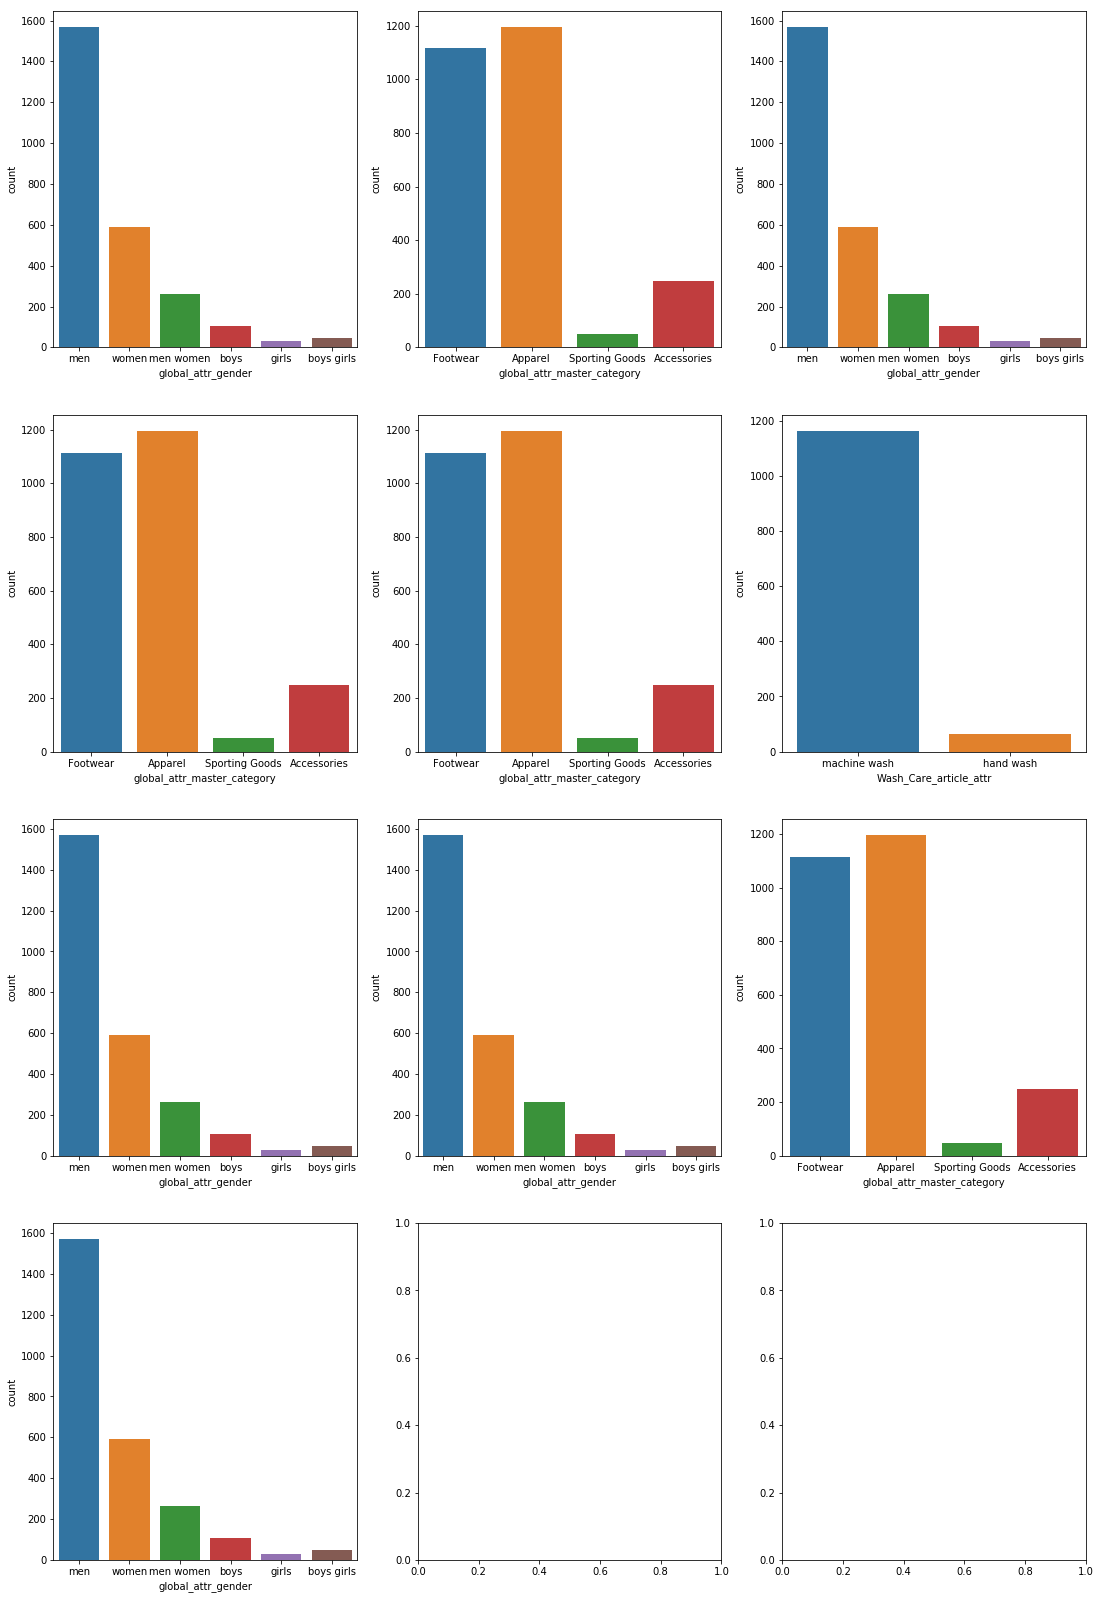

In [18]:
# for c in docs_df.columns :
l = len(label_attributes)
fig, axs = plt.subplots(4,(l+3)/4)
fig.set_size_inches(18.5, 28.5)
i=0
for label in label_attributes:
    if len(label) >0 :
        sns.countplot(docs_df[label.keys()[0]],ax=axs[i/((l+3)/4)][i%((l+3)/4)])
        print i,label.keys()[0]
        i=i+1

In [19]:
def is_parent_child(a,b) :
    return 0

In [20]:
relationships = {}
relationships['global_attr_master_category'] = {}
relationships['global_attr_master_category']['global_attr_sub_category'] = 1
relationships['global_attr_master_category']['global_attr_article_type'] = 1
relationships['global_attr_master_category']['global_attr_fashion_type'] = 1

relationships['global_attr_sub_category'] = {}
# relationships['global_attr_master_category']['global_attr_sub_category'] = 1
relationships['global_attr_sub_category']['global_attr_article_type'] = 1
relationships['global_attr_sub_category']['global_attr_fashion_type'] = 1







In [21]:
# docs_df[~(docs_df.global_attr_article_type.isin(['NA' ,'na' ,'nan' , None]))].global_attr_article_type.dropna().drop_duplicates()

In [22]:
# select_cluster_to_split(cluster_docs)

In [23]:
a = [10,3,5,4]
b = [21,2,3,7]
# a.sort()
# b.sort()
# a.reverse()
# b.reverse()

In [24]:
# docs_df['Multipack_Set_article_attr'].drop_duplicates()

In [25]:
docs_df.head(10)

Ankle_Height_article_attr    Body_or_Garment_Size_article_attr  \
0                   regular                                  NaN   
1                   regular                                  NaN   
2                   regular                                  NaN   
3                       NaN              garment measurements in   
4                   regular                                  NaN   
5                   regular                                  NaN   
6                   regular                                  NaN   
7                   regular                                  NaN   
8                       NaN  to-fit denotes body measurements in   
9                       NaN  to-fit denotes body measurements in   

  Fabric_article_attr Fastening_article_attr Length_article_attr  \
0                 NaN               lace-ups                 NaN   
1                 NaN               lace-ups                 NaN   
2                 NaN               lace-ups                 NaN   
3           polyester                    NaN             regular   
4                 NaN               lace-ups                 NaN   
5                 NaN               lace-ups                 NaN   
6                 NaN               lace-ups                 NaN   
7                 NaN               lace-ups                 NaN   
8           polyester                    NaN                 NaN   
9           polyester                    NaN                 NaN   

  Material_article_attr Number_of_Components_article_attr  \
0                  mesh                                 2   
1               textile                               NaN   
2               leather                                 2   
3                   NaN                               NaN   
4               textile                                 2   
5               textile                               NaN   
6                 suede                               NaN   
7             synthetic                               NaN   
8                   NaN                               NaN   
9                   NaN                                 1   

  Occasion_article_attr Pattern_article_attr  \
0                   NaN                  NaN   
1                   NaN                  NaN   
2              everyday                solid   
3                sports                solid   
4              everyday                solid   
5                   NaN                  NaN   
6              everyday                solid   
7                   NaN                  NaN   
8                   NaN                solid   
9                   NaN              printed   

  Print_or_Pattern_Type_article_attr Wash_Care_article_attr  \
0                                NaN                    NaN   
1                                NaN                    NaN   
2                                NaN                    NaN   
3                              solid           machine wash   
4                                NaN                    NaN   
5                                NaN                    NaN   
6                                NaN                    NaN   
7                                NaN                    NaN   
8                                NaN                    NaN   
9                                NaN           machine wash   

  global_attr_age_group global_attr_article_type global_attr_brand  \
0            Adults-Men             Sports Shoes              Nike   
1            Adults-Men             Sports Shoes              Nike   
2            Adults-Men             Casual Shoes              Nike   
3            Adults-Men                  Tshirts              Nike   
4          Adults-Women             Casual Shoes              Nike   
5            Adults-Men             Sports Shoes              Nike   
6            Adults-Men             Casual Shoes              Nike   
7            Adults-Men             Sports Shoes 